# Step 1: Imports

In [118]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import os 

# Step 2: Load Files

In [119]:
demographics = [
    'P07', 'P10', 'P11', 'P13', 'P14', 'P16', 'P17', 'P18', 'P22', 'P23', 
    'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 
    'P34', 'P35', 'P36'
]

## Step 2a: Load LSL Files

In [120]:
timings = []
for subject in demographics:
    path = os.path.join("data", "lsl", subject+"_lsl.tri")
    timing = pd.read_csv(path, sep=";", header=None, names=['time', 'onset', 'code'])
    timing['time'] = pd.to_datetime(timing['time']).dt.strftime('%H:%M:%S')
    timings.append(timing)
print(timings[0].shape)
print(timings[0].head())


(362, 3)
       time  onset  code
0  16:54:02   1583    30
1  16:54:16   1638    40
2  16:54:26   1675    90
3  16:54:35   1709    20
4  16:54:48   1757    50


## Step 2b: Load fNIRS Files

In [121]:
from scipy.stats import zscore
data = {}
for subject in demographics:
    path = os.path.join("data", "data_csvs", subject+".csv")
    fnir = pd.read_csv(path, sep=",", header=0)
    fnir = fnir.drop(columns=['Time'])
    # standardize the data by channel
    fnir = fnir.apply(zscore)
    

    data[subject] = fnir
print(data['P07'].head())

        Ch1       Ch2       Ch3       Ch4       Ch5       Ch6       Ch7  \
0 -0.344265  1.300073  1.832774 -0.887930 -0.207624  1.054426  1.424040   
1 -0.043563  2.562058 -0.167581  2.891486 -0.264353  1.683089  1.235679   
2  2.162913 -0.264095 -0.396215  1.580901  0.002871  1.394116  0.123256   
3  0.851153  2.043946 -0.677578  2.979124  1.307757 -1.076036 -0.109632   
4  0.285941  1.579658 -0.029958  1.671413  1.027549 -1.233513 -0.383056   

        Ch8       Ch9      Ch10  ...     Ch169     Ch170     Ch171     Ch172  \
0  0.198594  1.644049 -0.490279  ... -0.803572  0.308469  0.180514 -0.080661   
1  0.530382  1.011504 -0.394615  ... -1.591845 -0.604185 -0.723011 -0.758347   
2 -0.103417  0.173477 -0.369911  ... -1.599090 -1.084251 -1.313623 -1.186320   
3 -0.583261  0.361621 -0.536389  ... -1.597565 -1.118971 -1.539979 -1.409398   
4 -0.818783  0.331133 -0.566345  ... -1.320694 -1.061013 -1.627339 -1.484535   

      Ch173     Ch174     Ch175     Ch176     Ch177     Ch178  
0 -0

### filter channels to hbr and remove short separation channels

In [122]:
#import the channel info
channel_info = pd.read_csv("data/channel_info.csv", sep=",", header=0)
# filter for the hbr channels
hbr = channel_info[channel_info['type'] == "'hbr'"]

# drop short separation channels (anything above 28 will definitely be a short separation channel)
hbr = hbr[hbr['detector'] < 29]
hbr = hbr.reset_index(drop=True)
hbr.head(5)

,source,detector,type,channel
0,1,2,'hbr',Ch2
1,1,3,'hbr',Ch4
2,1,5,'hbr',Ch6
3,1,17,'hbr',Ch8
4,2,1,'hbr',Ch10


In [123]:
for sub in demographics:
    data[sub] = data[sub].loc[:, hbr['channel']]

print(data['P07'].head())

        Ch2       Ch4       Ch6       Ch8      Ch10      Ch12      Ch14  \
0  1.300073 -0.887930  1.054426  0.198594 -0.490279  1.239808  1.022827   
1  2.562058  2.891486  1.683089  0.530382 -0.394615  2.521916  1.168643   
2 -0.264095  1.580901  1.394116 -0.103417 -0.369911  0.449242 -0.203777   
3  2.043946  2.979124 -1.076036 -0.583261 -0.536389 -0.368066 -0.532009   
4  1.579658  1.671413 -1.233513 -0.818783 -0.566345 -0.774057 -0.999820   

       Ch16      Ch18      Ch20  ...     Ch144     Ch146     Ch148     Ch150  \
0 -0.598151 -1.566220 -0.636939  ...  1.713459 -0.221721  0.479469  0.172284   
1 -0.649866 -1.349247 -1.578352  ...  4.528635 -0.579591 -0.131661 -0.245968   
2 -0.572215 -0.760836 -0.951104  ...  0.955362 -0.796596 -0.321077 -0.624594   
3 -0.674949 -1.169790 -1.180530  ... -1.440580 -1.018979 -0.176755 -1.040349   
4 -0.713384 -1.195898 -1.169701  ... -2.541416 -1.099296 -0.211296 -1.176951   

      Ch152     Ch154     Ch164     Ch166     Ch170     Ch172  
0  0

## Step 2c: Load Workload File

In [124]:
#load the workload labels
workload = pd.read_csv("data/load/workload.csv")
workload['timestamp'] = workload['timestamp'].str.replace('.', ':')

workload.head()

,participant_number,shape,condition_string,adaptivity,trial,timestamp,time_in_trial,category,action,errortype,...,efficiency,extrinsic_load,intrinsic_load,condition,last_trial,trial_clipped,response,pred_prob,pred_side,load_label
0,1,A,S3,AT,1,16:58:30,65261,mediumbar,error,placement,...,NaN,1,1,3,0,1.0,0,0.846383,right,overload
1,1,A,S3,AT,1,16:58:38,72913,mediumbar,correct placement,NaN,...,12.500000,1,1,3,0,1.0,1,0.846383,right,optimal
2,1,A,S3,AT,1,16:58:58,93579,shortbar,correct placement,NaN,...,5.000000,1,1,3,0,1.0,1,0.846383,right,optimal
3,1,A,S3,AT,1,16:59:20,115454,longbar,correct placement,NaN,...,1.612903,1,1,3,0,1.0,1,0.846383,right,optimal
4,1,A,S3,AT,1,16:59:33,128411,longbar,correct placement,NaN,...,7.692308,1,1,3,0,1.0,1,0.846383,right,optimal


In [125]:
#separate the data into the different participants
workload_dict = {}
for i in range(len(demographics)):
    workload_dict[demographics[i]] = workload[workload['participant_number'] == int(demographics[i][1:])].iloc[:, :]
    workload_dict['P07']
workload_dict['P07']


,participant_number,shape,condition_string,adaptivity,trial,timestamp,time_in_trial,category,action,errortype,...,efficiency,extrinsic_load,intrinsic_load,condition,last_trial,trial_clipped,response,pred_prob,pred_side,load_label
159,7,A,A3,AT,1,17:06:55,37110,mediumbar,correct placement,NaN,...,NaN,0,1,1,0,1.0,1,0.885771,right,optimal
160,7,A,A3,AT,1,17:07:01,43041,shortbar,correct placement,NaN,...,2.173913,0,1,1,0,1.0,1,0.885771,right,optimal
161,7,A,A3,AT,1,17:07:13,54513,longbar,correct placement,NaN,...,8.333333,0,1,1,0,1.0,1,0.885771,right,optimal
162,7,A,A3,AT,1,17:07:22,63443,longbar,error,placement,...,0.000000,0,1,1,0,1.0,0,0.885771,right,overload
163,7,A,A3,AT,1,17:07:29,70721,longbar,correct placement,NaN,...,14.285714,0,1,1,0,1.0,1,0.885771,right,optimal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,7,D,S2,AT,7,17:36:12,7028,mediumbar,error,placement,...,0.000000,1,0,2,0,6.0,0,0.654617,right,overload
317,7,D,S2,AT,7,17:36:41,35791,mediumbar,error,length,...,0.000000,1,0,2,0,6.0,0,0.654617,right,overload
318,7,D,S2,AT,7,17:36:48,42264,shortbar,error,length,...,0.000000,1,0,2,0,6.0,0,0.654617,right,overload
319,7,D,S2,AT,7,17:36:52,46639,longbar,error,length,...,0.000000,1,0,2,0,6.0,0,0.654617,right,overload


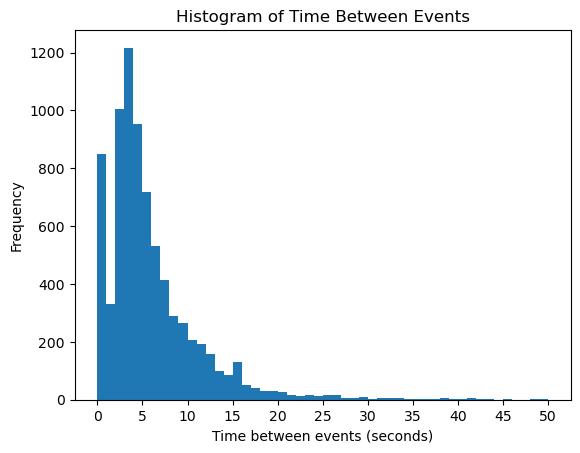

In [126]:
# Calcuate the time between each event
times = []
for sub in demographics:
    time = pd.to_datetime(timings[demographics.index(sub)]['time'], format='%H:%M:%S')
    for t in range(1, len(time)):
        times.append((time.iloc[t] - time.iloc[t-1]).total_seconds())
plt.hist(times, bins=np.arange(0, 51, 1))
plt.xlabel('Time between events (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Between Events')
plt.xticks(np.arange(0, 51, 5))
plt.show()



## Sanity Checks

In [127]:
P07 = data['P07']
onsets = timings[0]
print(P07.shape)
sample = onsets.iloc[0, 1]
fnirs_sample = P07.iloc[sample,:]
fnirs_sample.shape

(3020, 80)


(80,)

In [128]:
print(len(timings))
print(len(data))
print(len(demographics))

23
23
23


In [129]:
unique_participant_numbers = workload['participant_number'].unique()
print(unique_participant_numbers)

[ 1  7 15 16 17 18 23 24 25  8  9 10 11 12 13 14 22 26 27 28 29 30 31 32
 33 34 35 36]


In [130]:
# Use to convert to the 1Hz sampling rate of the fnirs data
sampling_rate = 3.8147
def get_onset_index(timing, sampling_rate):
    timing = timing / sampling_rate
    return int(timing)

# Step 3: Filter LSL --> Align Workload Timestamps with LSL Timestamps --> Output is Combined Dictionary

In [131]:
# Filter matched_df to get rows where the timestamp is in the 'time' column of the first DataFrame in timings
for i in range(len(demographics)):
    matched_times = timings[i][timings[i]['time'].isin(workload_dict[demographics[i]]['timestamp'])]
    workload_dict[demographics[i]] = workload_dict[demographics[i]].merge(matched_times, left_on='timestamp', right_on='time', how='left')
workload_dict['P07'].head()

,participant_number,shape,condition_string,adaptivity,trial,timestamp,time_in_trial,category,action,errortype,...,condition,last_trial,trial_clipped,response,pred_prob,pred_side,load_label,time,onset,code
0,7,A,A3,AT,1,17:06:55,37110,mediumbar,correct placement,NaN,...,1,0,1.0,1,0.885771,right,optimal,17:06:55,4533,103
1,7,A,A3,AT,1,17:07:01,43041,shortbar,correct placement,NaN,...,1,0,1.0,1,0.885771,right,optimal,17:07:01,4556,53
2,7,A,A3,AT,1,17:07:13,54513,longbar,correct placement,NaN,...,1,0,1.0,1,0.885771,right,optimal,17:07:13,4600,153
3,7,A,A3,AT,1,17:07:22,63443,longbar,error,placement,...,1,0,1.0,0,0.885771,right,overload,17:07:22,4634,163
4,7,A,A3,AT,1,17:07:29,70721,longbar,correct placement,NaN,...,1,0,1.0,1,0.885771,right,optimal,17:07:29,4661,153


In [ ]:
from sklearn.model_selection import GroupKFold
#parameters 
window_size = 4
#collating data and labels

X = []
y = []
groups = []

#iterate through the subjects
for sub in demographics:
    num_samples = 0
    sub_metadata = workload_dict[sub]
    sub_data = data[sub].to_numpy()
    for row in sub_metadata.itertuples():
        onset = row.onset
        label = row.load_label
        if(np.isnan(onset)):
            continue
        #Get the corresponding fnirs sample 
        index = get_onset_index(onset, sampling_rate)
        
        #Calculate the window and flatten to be compatible with the model
        fnirs_sample = sub_data[index-window_size+1:index+1].flatten()

        #check if the sample contains any NaN values
        if np.isnan(fnirs_sample).any():
            continue
        
        X.append(fnirs_sample)
        y.append(label)
        groups.append(sub)
    
    
X = np.array(X)
y = np.array(y)

#split into groups based on participants to ensure no crossover between train and test sets
groups = np.array(groups)
group_kfold = GroupKFold(n_splits=len(np.unique(groups)))
group_kfold.get_n_splits(X, y, groups)
#split into train and test
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(X_train.shape)
print(X_test.shape)


(4229, 320)
(176, 320)


In [133]:
#change from labels to ints
y_train = [0 if i == 'optimal' else 1 for i in y_train]
y_test = [0 if i == 'optimal' else 1 for i in y_test]

#print the distribution of the labels
print("Train distribution:")
print("Optimal: ", y_train.count(0))
print("Suboptimal: ", y_train.count(1))
print("Test distribution:")
print("Optimal: ", y_test.count(0))
print("Suboptimal: ", y_test.count(1))


Train distribution:
Optimal:  3486
Suboptimal:  743
Test distribution:
Optimal:  162
Suboptimal:  14


In [134]:
print(X_train.shape)
print(X_test.shape)

(4229, 320)
(176, 320)


In [135]:
# from sklearn import svm
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report
# from imblearn.over_sampling import SMOTE
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# from sklearn.utils import shuffle
# from sklearn.model_selection import StratifiedKFold

# # I wanted to try some features from my old assignment models (1/2)
# X_train, y_train = shuffle(X_train, y_train, random_state =1)
# X_test, y_test = shuffle(X_test, y_test, random_state=1)

# # Specific participants are being separated above
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
# sm = SMOTE(random_state=42)
# X_train, y_train = sm.fit_resample(X_train, y_train)

# # Should we standardize? Yes but only for SVM and not RF?
# # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# # scaler = StandardScaler()
# # X_train = scaler.fit_transform(X_train)
# # X_test = scaler.transform(X_test)

# # I wanted to try some features from my old assignment models (2/2)
# # Run only a subset to find the optimal hyperparameters
# # subset_size = int(0.3 * X_train.shape[0])
# # X_train = X_train[:subset_size]
# # y_train = y_train[:subset_size]
# # # subset_size = int(0.3 * X_test.shape[0])
# # X_test = X_test[:subset_size]
# # y_test = y_test[:subset_size]
# # Define parameter options
# parameters = [{'C': [1, 10], 'gamma': [0.1, 1, 'scale'], 'kernel': ['rbf', 'linear']},]
# # KFold
# cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
# # GridSearch to find best hyperparameters
# clf = GridSearchCV(SVC(class_weight='balanced'), param_grid=parameters, scoring='accuracy', cv=cv)

# # I tested out RF temporarily and it performed worse (at time of code - status may change)
# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# # clf = RandomForestClassifier(max_depth=2, random_state=0)

# # clf = svm.SVC()
# clf.fit(X_train, y_train)

# print("Best hyperparameters: ", clf.best_params_)

# y_train_pred = clf.predict(X_train)

# print("Training Accuracy:", accuracy_score(y_train, y_train_pred))


# y_pred = clf.predict(X_test)
# print(y_pred)

# print("Testing Accuracy:", accuracy_score(y_test, y_pred))

# print(classification_report(y_test, y_pred))




In [136]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# sm = SMOTE(random_state=42)
# X_train, y_train = sm.fit_resample(X_train, y_train)

ros = RandomUnderSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
clf = svm.SVC()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Testing Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))
print(y_pred)

{np.int64(0): np.int64(743), np.int64(1): np.int64(743)}
Testing Accuracy: 0.6818181818181818
              precision    recall  f1-score   support

           0       0.93      0.71      0.80       162
           1       0.10      0.36      0.15        14

    accuracy                           0.68       176
   macro avg       0.51      0.53      0.48       176
weighted avg       0.86      0.68      0.75       176

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1
 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
